In [1]:
import h5py
import jaxlie
import numpy as np
import bisect
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from tqdm import tqdm
%matplotlib inline
sequence_f_path = "../data/univrses/record_2022-04-22_07-17-55.hdf5"


sequence_f = h5py.File(sequence_f_path, 'r')
image_height = sequence_f["YUV420 Images"].attrs["image_height"]
image_width = sequence_f["YUV420 Images"].attrs["image_width"]

import pandas as pd
import h5py
sequence_f_path = "../data/univrses/record_2022-04-22_07-17-55.hdf5"

vehicle_detection_f = h5py.File(
            sequence_f_path.replace(".hdf5", '_vehicle_detections.hdf5'), 'r')
h5py.File(
            sequence_f_path.replace(".hdf5", '_vehicle_detections.hdf5'), 'r')

print("Loading detections")

detections = pd.DataFrame(list(map(lambda d: {"timestamp": int(d[0]), "type": d[1], "uuid": d[2],
                                                           "confidence": d[3], "top": d[4], "bottom": d[5],
                                                           "left": d[6], "right": d[7]}, tqdm(vehicle_detection_f["Detection"]))))





Loading detections


100%|██████████| 17562/17562 [00:09<00:00, 1915.23it/s]


In [2]:
# Load images
image_timestamps = list(tqdm(sequence_f["YUV420 Images"]["timestamp"]))


100%|██████████| 7915/7915 [00:00<00:00, 3122158.95it/s]


In [3]:
print(image_timestamps[:3])

[659517232112, 659583724787, 659616971125]


In [4]:
print( f"Image height: {image_height}, Image width: {image_width}")
print(detections.head(100)[90:])

Image height: 720, Image width: 1280
       timestamp  type      uuid  confidence  top  bottom  left  right
90  660781003526    29   [0, 91]    0.847656  446     486   404    477
91  660781003526    29   [0, 92]    0.656250  444     488   294    384
92  660781003526    29   [0, 93]    0.640625  461     534  1136   1251
93  660814249864    29   [0, 94]    0.796875  443     486   403    486
94  660814249864    29   [0, 95]    0.718750  418     506   763    930
95  660814249864    29   [0, 96]    0.621094  466     532  1135   1257
96  660847496202    29   [0, 97]    0.816406  444     485   393    480
97  660847496202    29   [0, 98]    0.640625  438     483   302    407
98  660880724430    29   [0, 99]    0.867188  439     485   302    410
99  660913970768    29  [0, 100]    0.656250  438     484   303    413


In [5]:
n_poses = len(sequence_f["FusionTimestampedPose"])
def get_pose_at_timestamp(timestamp):
    # Get camera extrinsics at timestamp
    pose_idx = bisect.bisect_left(
        sequence_f["FusionTimestampedPose"]["timestamp"], timestamp)
    if pose_idx >= n_poses:
        return None
    pose = sequence_f["FusionTimestampedPose"][pose_idx]
    # Interpolate between poses if timestamp is not exact
    if pose["timestamp"] != timestamp and pose_idx > 0:

        pose_idx -= 1
        pose = sequence_f["FusionTimestampedPose"][pose_idx]
        next_pose = sequence_f["FusionTimestampedPose"][pose_idx + 1]
        alpha = (timestamp - pose["timestamp"]) / \
            (next_pose["timestamp"] - pose["timestamp"])
        pose = [
            timestamp,
            (1 - alpha) * pose[1] + alpha * next_pose[1],
            "-"
        ]
    return pose

In [6]:
import cv2 
def get_image_at_timestamp(query_timestamp):
    image_idx = bisect.bisect_left(image_timestamps, query_timestamp)
    assert(image_timestamps[image_idx] == query_timestamp)
    image_byte_array_yuv = sequence_f['YUV420 Images'][image_idx]["bytes"]

    '''
    YUV420 with interleaved U and V , with uv_row_stride = y_row_stride = image_width.
    For more details look at N12 or N21: https://www.fourcc.org/pixel-format/yuv-nv12/
    '''
    e = image_width * image_height
    Y = image_byte_array_yuv[0:e]
    Y = np.reshape(Y, (image_height, image_width))
    V = image_byte_array_yuv[e::2]
    V = np.repeat(V, 2, 0)
    V = np.reshape(V, (int(image_height/2), image_width))
    V = np.repeat(V, 2, 0)
    U = image_byte_array_yuv[e+1::2]
    U = np.repeat(U, 2, 0)
    U = np.reshape(U, (int(image_height/2), image_width))
    U = np.repeat(U, 2, 0)

    RGBMatrix = (np.dstack([Y, U, V])).astype(np.uint8)
    RGBMatrix = cv2.cvtColor(RGBMatrix, cv2.COLOR_YUV2RGB, 3)
    return RGBMatrix

In [7]:
import math
def get_trajectory(start_timestamp: int = None, end_timestamp: int = None):

        if start_timestamp is None:
            start_timestamp = -math.inf
        if end_timestamp is None:
            end_timestamp = math.inf

        pose = []
        for data in sequence_f["FusionTimestampedPose"]:
            if data[0] < start_timestamp:
                continue
            if data[0] > end_timestamp:
                break
            pose.append([data[0], jaxlie.SE3.exp(data[1])])
        return np.array(pose)

In [8]:
# Camera intrinsics
fx = sequence_f["CameraModel"].attrs['fx'] 
fy = sequence_f["CameraModel"].attrs['fy']
cx = sequence_f["CameraModel"].attrs['cx']
cy = sequence_f["CameraModel"].attrs['cy']

# Distortion coefficients
k1 = sequence_f["CameraModel"].attrs['k1']
k2 = sequence_f["CameraModel"].attrs['k2']
p1 = sequence_f["CameraModel"].attrs['p1']
p2 = sequence_f["CameraModel"].attrs['p2']
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
K_2D = np.array([[fx, cx], [0, 1]])
camera_to_system = jaxlie.SE3.from_matrix( np.array([[0, -1,  0,  0 ],
[0,  0, -1,  0 ],
[1,  0,  0,  0 ],
[0,  0,  0,  1]])
)

In [27]:
def camera_ray_to_pixel(ray: np.array, se3: jaxlie.SE3):
    if ray.shape != (3,):
        print(f"Invalid dimensions {ray.shape}")
        return
    
    camera_coordinates = se3.inverse() @ ray
    system_coordinates = camera_to_system @ camera_coordinates
    pixel_coordinates = K @ system_coordinates
    return pixel_coordinates / pixel_coordinates[-1]




In [10]:
print(K)

[[890.19610596   0.         640.        ]
 [  0.         890.19610596 360.        ]
 [  0.           0.           1.        ]]


In [11]:
def pixel_to_3D_ray( pose, px: int, py: int, ray_length: int = 10, frame: str = "global"):

       

        # TODO: What to do at boundaries?
        se3 = jaxlie.SE3.exp(pose[1])
        R = se3.rotation()
        # X0 = se3.translation()
        image_pixel_coordinates = np.array([px, py, 1])

        # Pixel to camera coordinates
        camera_coordinates = np.linalg.inv(K) @ image_pixel_coordinates
        # Pick a point on the ray
        camera_coordinates = camera_coordinates / np.linalg.norm(camera_coordinates)
        camera_coordinates *= ray_length
        # Convert to homogeneous coordinates
        # camera_coordinates = np.append(camera_coordinates, 1) # 0 removes translation

        if frame == "local":
                # The camera has a different coordinate system to how we want to represent the image,
                # x forward, y left, z up translated into x right, y down, z forward (correct?)
                return camera_to_system.inverse() @ camera_coordinates

        

        camera_coordinates = camera_to_system.inverse() @ camera_coordinates
        # Describe in world coordinates
        world_coordinates =  se3 @ camera_coordinates

        



        return world_coordinates 

In [29]:
pose = get_pose_at_timestamp(0)
og_pixel = (100, 100)
ray = pixel_to_3D_ray(pose, og_pixel[0], og_pixel[1], frame="global")
pixel = camera_ray_to_pixel(ray, jaxlie.SE3.exp(pose[1]))
print(og_pixel)
print(pixel)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [12]:
trajectory = get_trajectory()

tx, ty, tz = np.array([[t[1].translation()[0], t[1].translation()[1], t[1].translation()[2]] for t in trajectory]).T



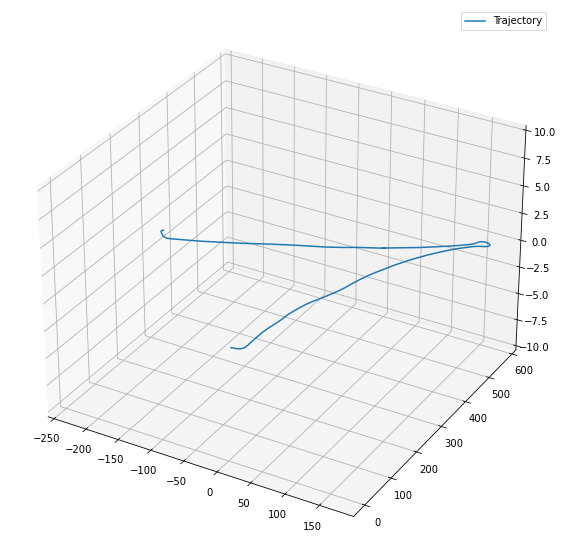

In [13]:
# Plot benchmark trajectory
fig = plt.figure("trajectory_global", figsize=(10, 10), )
ax = fig.add_subplot(111, projection='3d')
ax.plot(tx, ty, tz, label="Trajectory")
ax.set_zlim(-10, 10)
ax.legend()



In [14]:
run_nr = 0

In [ ]:
import mpl_toolkits.mplot3d.axes3d as p3
from tqdm import tqdm
from IPython.display import clear_output
import time
from functools import partial

# Plot according to the vehicle coordinate system

fig = plt.figure("trajectory", figsize=(20, 20), )




ax = fig.add_subplot(121, projection='3d')

image_ax = fig.add_subplot(122)
# Equal axis
ax.set_aspect('auto')
%matplotlib qt
plt.show()


# n_timesteps = len(sequence_f["YUV420 Images"])
n_timesteps = 30

timestep_indices= list(map(lambda x: int(x), np.linspace(0, len(sequence_f["YUV420 Images"]) - 1, n_timesteps)))
first_se3 = jaxlie.SE3.exp(sequence_f["FusionTimestampedPose"]["timestamp" == timestep_indices[0]][1])



# Heading will be fixed
heading = np.array([1, 0, 0]) * 10

# Save rays
rays = []


axis_lim = 300

iteration_times = []

detection_ray_length = 120


# Rotate view
# ax.view_init(azim=180, elev=20)

ax.plot3D(tx, ty, tz, 'b-', label="trajectory")


def animate(i: int, args): 
    start = args[0]
    index = timestep_indices[i]
    timestamp = sequence_f["YUV420 Images"][index][0]
    image = get_image_at_timestamp(timestamp)


   

    # Get camera extrinsics at timestamp
    pose = get_pose_at_timestamp(timestamp)
    if not pose:

        return ax, image_ax

    #  # Clear figures
    # ax.clear()
    # image_ax.clear()


    ax.set_title(f"Timestamp: {timestamp}")
    se3 = jaxlie.SE3.exp(pose[1])

    # inverse_transformation = se3.inverse()
   
    # Transform trajectory to the camera coordinate system
    # _tx, _ty, _tz = np.array([ inverse_transformation @ np.array([x, y, z]) for x, y, z in zip(tx, ty, tz)]).reshape(-1, 3).T
    # _tx, _ty, _tz = np.array(list(map(lambda t: (inverse_transformation @ t).translation(), trajectory[:, 1]))).reshape(-1, 3).T
 

    # Get left and right bound of camera 
    # TOP_LEFT = pixel_to_3D_ray(pose, 0, 0, frame="global", ray_length=100)
    # TOP_RIGHT = pixel_to_3D_ray(pose, image_width, 0, frame="global", ray_length=100)
    # BOTTOM_RIGHT = pixel_to_3D_ray(pose, image_width, image_height, frame="global", ray_length=100)
    # BOTTOM_LEFT = pixel_to_3D_ray(pose, 0, image_height, frame="global", ray_length=100)

    #  # Plot camera viewport
    # ax.plot3D([x, TOP_LEFT[0]], [y, TOP_LEFT[1]], [z, TOP_LEFT[2]], 'm-', linewidth=5)
    # ax.plot3D([x, TOP_RIGHT[0]], [y, TOP_RIGHT[1]], [z, TOP_RIGHT[2]], 'm-', linewidth=5)
    # ax.plot3D([x, BOTTOM_RIGHT[0]], [y, BOTTOM_RIGHT[1]],[ z, BOTTOM_RIGHT[2]], 'm-', linewidth=5)
    # ax.plot3D([x, BOTTOM_LEFT[0]], [y, BOTTOM_LEFT[1]],[ z, BOTTOM_LEFT[2]], 'm-', linewidth=5, label="viewport")


    

    x, y, z = se3.translation()
    # Plot the camera
    # ax.plot3D(x, y, z, 'ro')


    # # Show direction
    # rotation_matrix = se3.rotation().as_matrix()
    # heading = rotation_matrix @ np.array([1, 0, 0])
    # heading = heading / np.linalg.norm(heading) * 30
    # heading = heading + np.array([x, y, z])
    # ax.plot3D([x, heading[0]], [y, heading[1]], [z, heading[2]], 'r-', label="heading")






    image_ax.set_title(f"Timestamp: {timestamp}")

    # Get the closest detection (in time) to the image
    # d_index = bisect.bisect_left(detections["timestamp"], timestamp)
    # d_timestamp = detections.iloc[d_index]["timestamp"]
    current_detections = detections[detections["timestamp"] == timestamp]
    colors = pl.cm.jet(np.linspace(0,1,len(current_detections)))
    color_i = 0


 

    

    
    # Get rays to the bounding boxes
    for _, d in current_detections.iterrows():
        # Get the center of the bounding box
        width = d.right - d.left
        height = d.bottom - d.top

        center = pixel_to_3D_ray(pose, d.left + width / 2, d.top + height / 2, frame="global", ray_length=detection_ray_length)
        # Plot the center of the bounding box
        # rays.append({"origin": [x, y, z], "point": center})
        ax.plot3D([x, center[0]], [y, center[1]], [z, center[2]], '-', color=colors[color_i])
        # top_left = pixel_to_3D_ray(pose, d.left, d.top,  frame="global", ray_length=detection_ray_length)
        # top_right = pixel_to_3D_ray(pose, d.right, d.top,  frame="global", ray_length=detection_ray_length)
        # bottom_left = pixel_to_3D_ray(pose, d.left, d.bottom,  frame="global", ray_length=detection_ray_length)
        # bottom_right = pixel_to_3D_ray(pose, d.right, d.bottom,  frame="global", ray_length=detection_ray_length)

        # # Plot rays to the corners of the bounding box

        # ax.plot3D([x, top_left[0]],     [y, top_left[1]],     [z, top_left[2]], '-', color=colors[color_i])
        # ax.plot3D([x, top_right[0]],    [y, top_right[1]],    [z, top_right[2]], '-', color=colors[color_i])
        # ax.plot3D([x, bottom_right[0]], [y, bottom_right[1]], [z, bottom_right[2]], '-', color=colors[color_i])
        # ax.plot3D([x, bottom_left[0]],  [y, bottom_left[1]],  [z, bottom_left[2]], '-', color=colors[color_i], label="bounding box")

        # Draw detections on image
        rect = plt.Rectangle((d["left"], d["top"]), d["right"] -
                                 d["left"], d["bottom"] - d["top"], fill=False, color=colors[color_i])
        image_ax.add_patch(rect)
        break
        color_i +=1
        


   
    # for line in rays:
    #     origin = line["origin"]
    #     ray = line["point"]
    #     ax.plot3D([origin[0], ray[0]], [origin[1], ray[1]], [origin[2], ray[2]], '-', color="black")

    # Plot trajectory

  

    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    ax.set_zlim(-axis_lim, axis_lim)
    # ax.set_position([-.25, 0, 1, 1])
    # image_ax.set_position([.55, .3, .4, .4])









    # ax.legend()


    # image_ax.imshow(image)
    clear_output(wait=True)
    print(f"completion: {i / len(timestep_indices) * 100:.2f}%")
    execution_time = time.time() - start
    
    
    
    args[0] = time.time()
    iteration_times.append(execution_time)
    if len(iteration_times) > 10:
        iteration_times.pop(0)
    mean_time = np.mean(iteration_times)
    # Estimate time to finish 
    time_to_finish = (n_timesteps - i) * mean_time
    time_to_finish_minutes = int(time_to_finish / 60)
    time_to_finish_seconds = int(time_to_finish % 60)
    print(f"ETA: {time_to_finish_minutes}m {time_to_finish_seconds}s")
    return ax, image_ax

    plt.show()
    plt.pause(5)




save_movie = True

if save_movie:

    import matplotlib.animation as animation


    start = time.time()
    # creating animation
    ani = animation.FuncAnimation(fig,partial(animate, args=[start]), n_timesteps,interval=30)
    writer = animation.writers['ffmpeg'](fps=24)
    run_nr += 1
    ani.save(f'triangulation{run_nr}.mp4',writer=writer,dpi=100)
else:
    %matplotlib qt
    start = time.time()
    for i in range(n_timesteps):
        animate(i, args=[start])
        fig.canvas.draw()
        plt.show()







completion: 13.33%
ETA: 0m 14s


: 

In [ ]:
_pose = get_pose_at_timestamp(0)
ray = pixel_to_3D_ray(_pose, image_width, image_height)
print(ray)
pixel = camera_ray_to_pixel(ray)
print(pixel)


In [ ]:
trajectory = get_trajectory()
tx, ty = [t[1].translation()[0] for t in trajectory],[t[1].translation()[1] for t in trajectory]


In [27]:
def plot_traj_and_camera_viewport_at_timestep(timestamp, ax: plt.Axes = None):
        if ax is None:
                fig, ax = plt.subplots()
        # Get camera extrinsics at timestamp
        pose = get_pose_at_timestamp(timestamp)
        se3 = jaxlie.SE3.exp(pose[1])
        timeStep_idx = bisect.bisect_left(trajectory[:, 0], timestamp)
        position = trajectory[timeStep_idx]
        px, py = position[1].translation()[0], position[1].translation()[1]

        # Plot trajectory
        ax.plot(tx,
                ty )
        # Put red point at camera position
        ax.plot(px,
                 py, "ro")
        


        
        # Plot vehicle heading
        rotation_matrix = se3.rotation().as_matrix()
        heading = rotation_matrix @ np.array([1, 0, 0])
        heading = heading / np.linalg.norm(heading) * 60

        
        ax.arrow(px,py, heading[0], heading[1], head_width=1, head_length=1, fc='k', ec='k',)

        # Add camera viewport
        left_bound  = pixel_to_3D_ray(pose, 0, image_height, frame="global", ray_length=100)
        right_bound = pixel_to_3D_ray(pose, image_width, image_height, frame="global", ray_length=100)
        # print(left_bound)
        # print(right_bound)

     

        # Plot camera viewport
        ax.plot([px, left_bound[0]], [py,  left_bound[1]], "r-")
        ax.plot([px, right_bound[0]], [py,  right_bound[1]], "g-")





        # print({"left_bound": left_bound, "right_bound": right_bound})


        
        
        


        # plt.show()
        if ax is None:
                plt.show()
        
        return ax

In [29]:
%matplotlib qt

plot_traj_and_camera_viewport_at_timestep(713711463541)




<AxesSubplot:>

In [ ]:
# importing movie py libraries
import matplotlib.animation as animation
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import clear_output


n_frames = 100
# Create a video of the trajectory and camera viewport
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.set_size_inches([5,5])

timesteps_indices = list(map(lambda x: int(x), np.linspace(0, len(np.array(sequence_f["FusionTimestampedPose"]["timestamp"])) - 1, n_frames)))

im = ax.imshow(255 * np.ones((image_height, image_width, 3)))
def animate(i):
    ax.clear()
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    idx = timesteps_indices[i]
    timestep = sequence_f["FusionTimestampedPose"][idx][0]
    clear_output(wait=True)
    print(f"timestep: {timestep} {round(i/n_frames*100, 2)}% done")
    plot_traj_and_camera_viewport_at_timestep(timestep, ax=ax)
    image = mplfig_to_npimage(fig)
    im.set_data(image)


    return im

# creating animation
ani = animation.FuncAnimation(fig,animate,n_frames,interval=30)
writer = animation.writers['ffmpeg'](fps=5)

ani.save('demo.mp4',writer=writer,dpi=100)


timestep: 813791288189 64.0% done


# Triangulation


Camera pose



In [7]:
from vehicle import System
sys = System(

        "/Users/emanuelwreeby/Plugg/Terminer/Exjobb/src/data/univrses/record_2022-04-22_07-17-55.hdf5")



In [8]:

sys.load_detections()

In [3]:
import numpy as np
random_detection = sys.detections[sys.detections["uuid"][:, -1] == 3203][0]

In [4]:
random_detection

(693660749650, 29, [   0, 3203], 0.6875, 394, 518, 531, 866, 693660749650)

In [5]:
box_center = np.array([random_detection["left"] + (random_detection["right"] - random_detection["left"])/2, random_detection["top"] + (random_detection["bottom"] - random_detection["top"])/2])

se3 = sys.get_pose_at_timestamp(random_detection["timestamp"])["se3"]
ray = sys.camera.ray_cast(se3, box_center)

# ray_direction = ray[0, 3:] - ray[0, :3]
# ray_direction = ray_direction / np.linalg.norm(ray_direction)
# point = ray_direction * 100010
point = np.array(ray[0][3:])

# Project the ray back to the image plane
pixel = sys.camera.project_onto_camera(se3,  point)
print(box_center)
print(pixel)

[698.5 456. ]
[698.5 456. ]


In [11]:
print(id(sys))
test = sys
print(id(test))

140158091331232
140158091331232
